# Lab 3-2: Analysis of Variance (ANOVA)

For this example, we are interested in how different fertilizer treatments have affected plant growth (as measured by plant height).

Also note, you can find a nice online tutorial on [ANOVA using python  here](https://reneshbedre.github.io/blog/anova.html). ANOVA is one of the most commonly used stats tools, so many video and online resources exist.  If you find an especially good one, please let me know!

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
# load data file (note that we are specifying a separator other than the default comma in read_csv, the symbol for "tab" is "\t")
df = pd.read_csv("data/ANOVA_fertilizer_treatment.txt", sep="\t")

NameError: name 'pd' is not defined

If we look at the dataframe we just loaded, we can see that we have one control group (no fertilizer) and three different fertilizer treatments.

In [3]:
df

,Control,F1,F2,F3
0,21.0,32.0,22.5,28.0
1,19.5,30.5,26.0,27.5
2,22.5,25.0,28.0,31.0
3,21.5,27.5,27.0,29.5
4,20.5,28.0,26.5,30.0
5,21.0,28.6,25.2,29.2


We can make a boxplot to visualize our data and their distributions.

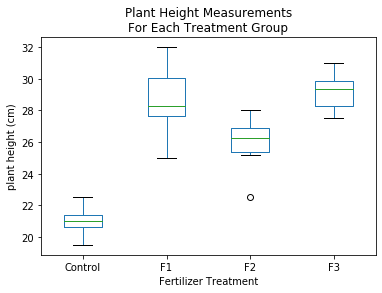

In [4]:
# Using boxplot, we can start to visually see differences between the treatment groups
df.boxplot(column=['Control', 'F1', 'F2', 'F3'], grid=False)

# Add labels
plt.xlabel('Fertilizer Treatment')
plt.ylabel('plant height (cm)')
plt.title('Plant Height Measurements\nFor Each Treatment Group');

**State our null and alternative hypothesis:**

$H_0$: All groups have the same central mean

$H_1$: The means are different from each other

We want 95% confidence, so choose $\alpha = 0.05$

In this case, we perform a one-way (also called one-factor) ANOVA to determine whether our null hypothesis ($H_0$) is true or not. We can use the [scipy.stats.f_oneway()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html) function for this. This function will return the F-statistic, and a p-value. **We can reject the null hypothesis if $p < \alpha$**

In [5]:
# stats f_oneway functions takes the groups as input and returns an F and P-value
fvalue, pvalue = stats.f_oneway(df['Control'], df['F1'], df['F2'], df['F3'])

# print the results
print("F-statistic = {}".format( np.round(fvalue,2)))
print("p = {}".format( pvalue ))

F-statistic = 27.46
p = 2.711994408537598e-07


Our p-value is smaller than our chosen $\alpha$, so in this case we can reject the null hypothesis.




Take a look at the lecture notes to recall how the F-statistic is calculated.

The p-value for this test is determined by looking up that F-statistic in the [F-distribution](https://en.wikipedia.org/wiki/F-distribution).  The p-value is this example much less than 0.05, so we can reject the null. However, if we want to know more, such as which of the groups are actually different from which other groups, we need more information.

---
We are going to use functions from the [statsmodels](https://www.statsmodels.org/stable/index.html) python package for the examples below.

In [6]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

The following code will produce an ANOVA table with our results using the [statsmodels.stats.anova.anova_lm()](https://www.statsmodels.org/dev/generated/statsmodels.stats.anova.anova_lm.html) function.

In [7]:
# reshape the d dataframe suitable for statsmodels package 
df_reshaped = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['Control', 'F1', 'F2', 'F3'])

# replace column names
df_reshaped.columns = ['index', 'treatments', 'value']

# Ordinary Least Squares (OLS) model
model = ols('value ~ C(treatments)', data=df_reshaped).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# display the results table
anova_table

,sum_sq,df,F,PR(>F)
C(treatments),251.440000,3.0,27.464773,2.711994e-07
Residual,61.033333,20.0,NaN,NaN


Compare the above to the table we made in class.  Both of these python packages are valid ways to solve the basic problem.

---

However, we need to apply Tukey's test to tell which groups are different from which other groups. [Read the documentation for the pairwise_tukeyhsd function here](https://www.statsmodels.org/stable/generated/statsmodels.stats.multicomp.pairwise_tukeyhsd.html).

In [8]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [9]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df_reshaped['value'], groups=df_reshaped['treatments'], alpha=0.05)

# display the results table
print(m_comp)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Control     F1      7.6  0.001  4.7769 10.4231   True
Control     F2   4.8667  0.001  2.0436  7.6897   True
Control     F3      8.2  0.001  5.3769 11.0231   True
     F1     F2  -2.7333 0.0599 -5.5564  0.0897  False
     F1     F3      0.6    0.9 -2.2231  3.4231  False
     F2     F3   3.3333 0.0171  0.5103  6.1564   True
-----------------------------------------------------


The "reject" column in this table shows us that all of the fertilizer treatments are different from the control (reject=True, we can reject the null hypothesis), and that treatments F2 and F3 are different from each (reject=True) other but not from F1 (reject=False).

Look at the boxplot graph above again. The boxplots shows the interquartile ranges and plus and minus 1.5 times the interquartile range -- these are related to the 95% confidence range but do not show it exactly.  Note that the lower and upper ranges shown in the Tukey table above suggest a real difference if the 95% confidence range does not include 0.  (If it includes 0, then there's a greater than 5% chance that there's really no difference at all.)

This is the extent of what you need to complete the homework problem. I encourage you to read the details about each of these functions, review the lecture notes, or other resources you can find online. Chapter 7 of the [USGS book](https://pubs.usgs.gov/tm/04/a03/tm4a3.pdf) covers in much more detail one-factor ANOVA as well as several more tests for comparing multiple groups of samples.